In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cross_validation import KFold, cross_val_score
#Settings
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 100)

In [3]:
raw_email = pd.read_csv('hackerrank/predict_email/training_dataset.csv')
test_email = pd.read_csv('hackerrank/predict_email/test_dataset.csv')
print(raw_email.shape)
print(test_email.shape)

(486048, 54)
(207424, 48)


In [16]:
#functions
def binary_output(x):
    if x ==False:
        return 0
    elif x == True:
        return 1
    else:
        return x

def weekend_binary(x):
    time_obj = time.gmtime(int(x))
    if time_obj.tm_wday > 4:
        return 1
    else:
        return 0

def month_label(x):
    month_dict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    time_obj = time.gmtime(x).tm_mon
    return month_dict[time_obj]

def hour_of_day_label(x):
    hour_dict = {}
    for i in range(0,25):
        hour_dict[i] = '{}_oclock'.format(i)
    time_obj = time.gmtime(x).tm_hour
    return hour_dict[time_obj]

def days_online_sent(row):
    sent = datetime.datetime.utcfromtimestamp(row['sent_time_with_timezone'])
    online = datetime.datetime.utcfromtimestamp(row['last_online_with_timezone'])
    days_online = sent - online
    return days_online.days

def days_existence_sent(row):
    sent = datetime.datetime.utcfromtimestamp(row['sent_time_with_timezone'])
    created = datetime.datetime.utcfromtimestamp(row['hacker_created_at_with_timezone'])
    existence_sent = sent - created
    return existence_sent.days

# Normalising Functions
def normalise_contest_login(df):
    cols = ['contest_login_count_1_days','contest_login_count_7_days','contest_login_count_30_days',
            'contest_login_count_365_days','contest_login_count']
    norm_cols = ['norm_contest_login_0_1', 'norm_contest_login_1_7','norm_contest_login_7_30',
                 'norm_contest_login_30_365','norm_contest_login_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_contest_participation(df):
    cols = ['contest_participation_count_1_days','contest_participation_count_7_days','contest_participation_count_30_days',
            'contest_participation_count_365_days','contest_participation_count']
    norm_cols = ['norm_contest_participation_0_1', 'norm_contest_participation_1_7','norm_contest_participation_7_30',
                 'norm_contest_participation_30_365','norm_contest_participation_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_ipn_count(df):
    cols = ['ipn_count_1_days','ipn_count_7_days','ipn_count_30_days',
            'ipn_count_365_days','ipn_count']
    norm_cols = ['norm_ipn_count_0_1', 'norm_ipn_count_1_7','norm_ipn_count_7_30',
                 'norm_ipn_count_30_365','norm_ipn_count_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_ipn_read(df):
    cols = ['ipn_read_1_days','ipn_read_7_days','ipn_read_30_days',
            'ipn_read_365_days','ipn_read']
    norm_cols = ['norm_ipn_read_0_1', 'norm_ipn_read_1_7','norm_ipn_read_7_30',
                 'norm_ipn_read_30_365','norm_ipn_read_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_submissions_count(df):
    cols = ['submissions_count_1_days','submissions_count_7_days','submissions_count_30_days',
            'submissions_count_365_days','submissions_count']
    norm_cols = ['norm_submissions_count_0_1', 'norm_submissions_count_1_7','norm_submissions_count_7_30',
                 'norm_submissions_count_30_365','norm_submissions_count_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_submissions_count_contest(df):
    cols = ['submissions_count_contest_1_days','submissions_count_contest_7_days','submissions_count_contest_30_days',
            'submissions_count_contest_365_days','submissions_count_contest']
    norm_cols = ['norm_submissions_count_contest_0_1', 'norm_submissions_count_contest_1_7','norm_submissions_count_contest_7_30',
                 'norm_submissions_count_contest_30_365','norm_submissions_count_contest_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_submissions_count_master(df):
    cols = ['submissions_count_master_1_days','submissions_count_master_7_days','submissions_count_master_30_days',
            'submissions_count_master_365_days','submissions_count_master']
    norm_cols = ['norm_submissions_count_master_0_1', 'norm_submissions_count_master_1_7','norm_submissions_count_master_7_30',
                 'norm_submissions_count_master_30_365','norm_submissions_count_master_365_more']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[4]] #0-1
    norm_data[norm_cols[1]] = (data[cols[1]] - data[cols[0]]) / data[cols[4]] #1-7
    norm_data[norm_cols[2]] = (data[cols[2]] - data[cols[1]]) / data[cols[4]] #7-30
    norm_data[norm_cols[3]] = (data[cols[3]] - data[cols[2]]) / data[cols[4]] #30-365
    norm_data[norm_cols[4]] = (data[cols[4]] - data[cols[3]]) / data[cols[4]] #365 more
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data

def normalise_forum_count(df):
    cols = ['forum_comments_count', 'forum_expert_count', 'forum_questions_count','forum_count']
    norm_cols = ['norm_forum_comments_count','norm_forum_expert_count', 'norm_forum_questions_count']
    data = df[cols]
    norm_data = pd.DataFrame(columns=norm_cols)
    norm_data[norm_cols[0]] = (data[cols[0]]) / data[cols[3]] # comments
    norm_data[norm_cols[1]] = (data[cols[1]]) / data[cols[3]] # expert comment
    norm_data[norm_cols[2]] = (data[cols[2]]) / data[cols[3]] # questions
    norm_data[norm_data.isnull()==True] = int(0)
    return norm_data



In [78]:
def clean_data(df, kind):
    # Feature Extraction
    #Target variable creation for binary outputs
    if kind=='train':
        df['opened_binary'] = df.opened.apply(binary_output)

    #sent time and weekend binary features
    df.hacker_timezone = df.hacker_timezone.fillna(0)
    df['sent_time_with_timezone'] = df.sent_time + df.hacker_timezone
    df['weekend_binary'] = df['sent_time_with_timezone'].apply(weekend_binary)

    #hour of day email sent
    df['hour_of_day'] = df.sent_time_with_timezone.apply(hour_of_day_label)

    #hacker confirmation
    df['hacker_confirmation_binary'] = df.hacker_confirmation.apply(binary_output)

    #number of days between last online and sent variable (in days to match the other variables in the dataset) 
    df.last_online = raw_email.last_online.fillna(0)
    df['last_online_with_timezone'] = df.last_online + raw_email.hacker_timezone
    df['days_since_online_and_sent'] = df.apply(days_online_sent, axis=1)
    df['days_since_online_and_sent'][df['days_since_online_and_sent']<0] = 0
    df['days_since_online_and_sent'][df['days_since_online_and_sent']>1000] = 1000 # from above analysis
    
    df.hacker_created_at = df.hacker_created_at.fillna(0)
    df['hacker_created_at_with_timezone'] = df.hacker_created_at + df.hacker_timezone
    df['days_since_existence'] = df.apply(days_existence_sent, axis=1)
    
    norm_contest_login_df = normalise_contest_login(df)
    norm_contest_participation_df = normalise_contest_participation(df)
    norm_ipn_count_df = normalise_ipn_count(df)
    norm_ipn_read_df = normalise_ipn_read(df)
    norm_submissions_count_df = normalise_submissions_count(df)
    norm_submissions_count_contest_df = normalise_submissions_count_contest(df)
    norm_submissions_count_master_df = normalise_submissions_count_master(df)
    norm_forum_count_df = normalise_forum_count(df)
    
    mail_cat_dummies = pd.get_dummies(df.mail_category, prefix='dummy')
    mail_type_dummies = pd.get_dummies(df.mail_type, prefix='dummy')
    hour_dummies = pd.get_dummies(df['hour_of_day'], prefix='dummy')
    
    if kind=='train':
        training_cols = ['weekend_binary',
                         'days_since_online_and_sent',
                         'days_since_existence',
                         'hacker_confirmation_binary',
                         'opened_binary']
    elif kind=='test':
        training_cols = ['weekend_binary',
                         'days_since_online_and_sent',
                         'days_since_existence',
                         'hacker_confirmation_binary']
    
    all_data = [norm_contest_login_df, norm_contest_participation_df, norm_ipn_count_df, norm_ipn_read_df,
                norm_submissions_count_df, norm_submissions_count_contest_df, norm_submissions_count_master_df,
                norm_forum_count_df, mail_cat_dummies , mail_type_dummies, hour_dummies,
                df[training_cols]]
    data = pd.concat(all_data,axis=1)
    return data

train_data = clean_data(raw_email,'train')
train_data.head(3)

norm_contest_login_0_1  norm_contest_login_1_7  norm_contest_login_7_30  \
0                     0.0                     0.0                 0.000000   
1                     0.0                     0.0                 0.333333   
2                     0.0                     0.0                 0.000000   

   norm_contest_login_30_365  norm_contest_login_365_more  \
0                   1.000000                          0.0   
1                   0.666667                          0.0   
2                   1.000000                          0.0   

   norm_contest_participation_0_1  norm_contest_participation_1_7  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   

   norm_contest_participation_7_30  norm_contest_participation_30_365  \
0                         0.000000                           1.000000   
1                         0.333333                           0.666667   
2                         0.000000                           1.000000   

   norm_contest_participation_365_more  norm_ipn_count_0_1  \
0                                  0.0                 0.0   
1                                  0.0                 0.0   
2                                  0.0                 0.0   

   norm_ipn_count_1_7  norm_ipn_count_7_30  norm_ipn_count_30_365  \
0            0.000000             0.176471               0.823529   
1            0.000000             0.166667               0.833333   
2            0.021739             0.000000               0.978261   

   norm_ipn_count_365_more  norm_ipn_read_0_1  norm_ipn_read_1_7  \
0                      0.0                0.0                0.0   
1                      0.0                0.0                0.0   
2                      0.0                0.0                0.0   

   norm_ipn_read_7_30  norm_ipn_read_30_365  norm_ipn_read_365_more  \
0                 0.0                   0.0                     0.0   
1                 1.0                   0.0                     0.0   
2                 0.0                   0.0                     0.0   

   norm_submissions_count_0_1  norm_submissions_count_1_7  \
0                         0.0                    0.000000   
1                         0.0                    0.040404   
2                         0.0                    0.000000   

   norm_submissions_count_7_30  norm_submissions_count_30_365  \
0                     0.000000                       1.000000   
1                     0.424242                       0.535354   
2                     0.187500                       0.812500   

   norm_submissions_count_365_more  norm_submissions_count_contest_0_1  \
0                              0.0                                 0.0   
1                              0.0                                 0.0   
2                              0.0                                 0.0   

   norm_submissions_count_contest_1_7  norm_submissions_count_contest_7_30  \
0                                 0.0                               0.0000   
1                                 0.0                               0.1875   
2                                 0.0                               0.0000   

   norm_submissions_count_contest_30_365  \
0                                 0.0000   
1                                 0.8125   
2                                 0.0000   

   norm_submissions_count_contest_365_more  norm_submissions_count_master_0_1  \
0                                      0.0                                0.0   
1                                      0.0                                0.0   
2                                      0.0                                0.0   

   norm_submissions_count_master_1_7  norm_submissions_count_master_7_30  \
0                           0.000000                             0.00000   
1                    

In [79]:
test_data = clean_data(test_email,'test')
test_data.head(3)

norm_contest_login_0_1  norm_contest_login_1_7  norm_contest_login_7_30  \
0                     0.0                     0.0                      0.0   
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   

   norm_contest_login_30_365  norm_contest_login_365_more  \
0                   0.000000                     1.000000   
1                   0.333333                     0.666667   
2                   1.000000                     0.000000   

   norm_contest_participation_0_1  norm_contest_participation_1_7  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   

   norm_contest_participation_7_30  norm_contest_participation_30_365  \
0                              0.0                                0.0   
1                              0.0                                0.5   
2                              0.0                                1.0   

   norm_contest_participation_365_more  norm_ipn_count_0_1  \
0                                  1.0                 0.0   
1                                  0.5                 0.0   
2                                  0.0                 0.0   

   norm_ipn_count_1_7  norm_ipn_count_7_30  norm_ipn_count_30_365  \
0            0.000000                  0.0               1.000000   
1            0.000000                  0.0               0.954545   
2            0.021739                  0.0               0.978261   

   norm_ipn_count_365_more  norm_ipn_read_0_1  norm_ipn_read_1_7  \
0                 0.000000                0.0                0.0   
1                 0.045455                0.0                0.0   
2                 0.000000                0.0                0.0   

   norm_ipn_read_7_30  norm_ipn_read_30_365  norm_ipn_read_365_more  \
0                 0.0                   0.0                     0.0   
1                 0.0                   0.0                     0.0   
2                 0.0                   0.0                     0.0   

   norm_submissions_count_0_1  norm_submissions_count_1_7  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   

   norm_submissions_count_7_30  norm_submissions_count_30_365  \
0                       0.0000                       1.000000   
1                       0.0000                       0.885714   
2                       0.1875                       0.812500   

   norm_submissions_count_365_more  norm_submissions_count_contest_0_1  \
0                         0.000000                                 0.0   
1                         0.114286                                 0.0   
2                         0.000000                                 0.0   

   norm_submissions_count_contest_1_7  norm_submissions_count_contest_7_30  \
0                                 0.0                                  0.0   
1                                 0.0                                  0.0   
2                                 0.0                                  0.0   

   norm_submissions_count_contest_30_365  \
0                               0.000000   
1                               0.428571   
2                               0.000000   

   norm_submissions_count_contest_365_more  norm_submissions_count_master_0_1  \
0                                 0.000000                                0.0   
1                                 0.571429                                0.0   
2                                 0.000000                                0.0   

   norm_submissions_count_master_1_7  norm_submissions_count_master_7_30  \
0                                0.0                              0.0000   
1                    

In [81]:
print(train_data.shape)
print(test_data.shape)

print(train_data[test_data.columns].shape)

(486048, 89)
(207424, 81)
(486048, 81)


In [82]:
def train_model(df1,df2,sample_size=0.05):
    data_groups = df1.groupby(['opened_binary',
                              'dummy_mail_type_1',
                              'dummy_mail_type_2',
                              'dummy_mail_type_3',
                              'dummy_mail_type_4'])
    idx_sample = []
    for i, j in data_groups.groups.items():
        for idx in range(int(len(j)*sample_size)):
            idx_sample.append(j[idx])
    
    sample_data = df1.iloc[idx_sample,:]
    sample_data = sample_data.reset_index(drop=True)
    sample_target = sample_data['opened_binary']
    sample_data = sample_data[df2.columns]
    
    #Model - Best Model
    rf2_model = RandomForestClassifier(n_estimators=100,min_samples_leaf=5,min_samples_split=1)
    #rf2_model = RandomForestClassifier(n_estimators=100)
    rf2_model.fit(sample_data, sample_target)

    return rf2_model


model = train_model(train_data,test_data,sample_size=0.75)
model.score(train_data[test_data.columns],train_data.iloc[:,-1:])

0.77120572453749425

In [84]:
kf = KFold(len(train_data),n_folds=10, shuffle=True, random_state=123)
cross_val_score(model,train_data[test_data.columns],train_data['opened_binary'], cv=kf)

array([ 0.6986524 ,  0.70342557,  0.69558687,  0.70068923,  0.69805576,
        0.69712992,  0.70184137,  0.69881699,  0.7025142 ,  0.70199984])

In [ ]:
train_data = clean_data(raw_email,'train')
test_data = clean_data(test_email,'test')
model = train_model(train_data,sample_size=0.75)
model.predict(test_data)

In [86]:
predictions = model.predict(test_data)

In [74]:
test_data.head()

norm_contest_login_0_1  norm_contest_login_1_7  norm_contest_login_7_30  \
0                     0.0                     0.0                      0.0   
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   
3                     0.0                     0.0                      0.0   
4                     0.0                     0.0                      0.0   

   norm_contest_login_30_365  norm_contest_login_365_more  \
0                   0.000000                     1.000000   
1                   0.333333                     0.666667   
2                   1.000000                     0.000000   
3                   0.500000                     0.500000   
4                   0.000000                     1.000000   

   norm_contest_participation_0_1  norm_contest_participation_1_7  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0                             0.0   

   norm_contest_participation_7_30  norm_contest_participation_30_365  \
0                              0.0                                0.0   
1                              0.0                                0.5   
2                              0.0                                1.0   
3                              0.0                                0.5   
4                              0.0                                0.0   

   norm_contest_participation_365_more  norm_ipn_count_0_1  \
0                                  1.0                 0.0   
1                                  0.5                 0.0   
2                                  0.0                 0.0   
3                                  0.5                 0.0   
4                                  1.0                 0.0   

   norm_ipn_count_1_7  norm_ipn_count_7_30  norm_ipn_count_30_365  \
0            0.000000                  0.0               1.000000   
1            0.000000                  0.0               0.954545   
2            0.021739                  0.0               0.978261   
3            0.000000                  0.0               1.000000   
4            0.000000                  0.0               1.000000   

   norm_ipn_count_365_more  norm_ipn_read_0_1  norm_ipn_read_1_7  \
0                 0.000000                0.0                0.0   
1                 0.045455                0.0                0.0   
2                 0.000000                0.0                0.0   
3                 0.000000                0.0                0.0   
4                 0.000000                0.0                0.0   

   norm_ipn_read_7_30  norm_ipn_read_30_365  norm_ipn_read_365_more  \
0                 0.0                   0.0                     0.0   
1                 0.0                   0.0                     0.0   
2                 0.0                   0.0                     0.0   
3                 0.0                   0.0                     0.0   
4                 0.0                   0.0                     0.0   

   norm_submissions_count_0_1  norm_submissions_count_1_7  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   norm_submissions_count_7_30  norm_submissions_count_30_365  \
0                      0.00000                       1.000000   
1                      0.00000                       0.885714   
2                      0.18750                       0.812500   
3                      0.00000                       1.000000 

Below is a graph to show why I decided to assign people above 1000 to 1000. The curve plateaus at 1000 and sharply dips arond 17,000. These outliers would skew the data and so I chose to limit the range to where maximum information gain was achieved.

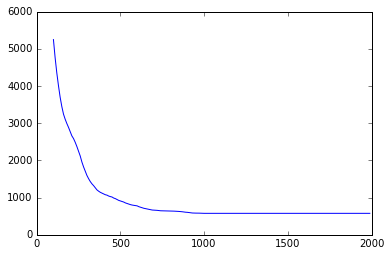

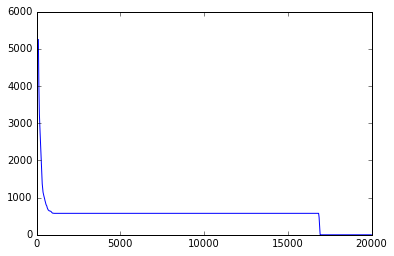

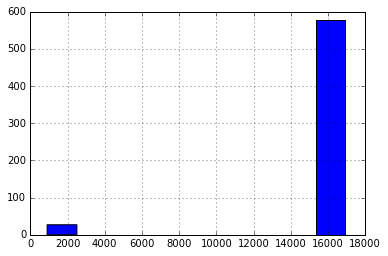

In [14]:
#days online threshold analysis
x_values = range(100,2000, 10)
y_values = [(len(raw_email['days_since_online_and_sent'][raw_email['days_since_online_and_sent']>x])) for x in x_values]
plt.plot(x_values,y_values)
plt.show()
x_values = range(100,20000, 10)
y_values = [(len(raw_email['days_since_online_and_sent'][raw_email['days_since_online_and_sent']>x])) for x in x_values]
plt.plot(x_values,y_values)
plt.show()
raw_email['days_since_online_and_sent'][raw_email['days_since_online_and_sent']>900].hist()
plt.show()

Below I assessed different classification models. After finding the best one, I used a gridsearch to find the optimal parameters and used it within my functions for predicting the test set due to the model being more generalised


In [49]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score

lr_model = LogisticRegression()
lr_model.fit(train_data.iloc[:,:-1], train_data['opened_binary'])
lr_model.score(train_data.iloc[:,:-1], train_data['opened_binary'])

#kf = KFold(len(train_data),n_folds=10, shuffle=True, random_state=123)
#cross_val_score(lr_model, train_data.iloc[:,:-1], train_data['opened_binary'], cv=kf)

0.66973426492856669

In [50]:
# Support Vector Machines

from sklearn.svm import LinearSVC
from sklearn.cross_validation import KFold, cross_val_score

svm_model = LinearSVC(C=0.01)
svm_model.fit(train_data.iloc[:,:-1], train_data['opened_binary'])
svm_model.score(train_data.iloc[:,:-1], train_data['opened_binary'])

# kf = KFold(len(train_data),n_folds=10, shuffle=True, random_state=123)
# cross_val_score(svm_model, train_data.iloc[:,:-1], train_data['opened_binary'], cv=kf)

0.66930632365527687

In [56]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, cross_val_score

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(train_data.iloc[:,:-1], train_data['opened_binary'])
rf_model.score(train_data.iloc[:,:-1], train_data['opened_binary'])

# kf = KFold(len(new_sample_data),n_folds=10, shuffle=True, random_state=123)
# cross_val_score(rf_model, new_sample_data.iloc[:,:-1], new_sample_data['opened_binary'], cv=kf)

0.97803509118440979

In [51]:
#Ada Boost Classifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.cross_validation import KFold, cross_val_score

boost_model = AdaBoostClassifier(n_estimators=100)
boost_model.fit(train_data.iloc[:,:-1], train_data['opened_binary'])
boost_model.score(train_data.iloc[:,:-1], train_data['opened_binary'])

# kf = KFold(len(new_sample_data),n_folds=10, shuffle=True, random_state=123)
# cross_val_score(boost_model, new_sample_data.iloc[:,:-1], new_sample_data['opened_binary'], cv=kf)

0.67183488050562912

In [ ]:
from sklearn.grid_search import GridSearchCV

param_grid = {'min_samples_leaf': [1,2,3,4,5],
             'min_samples_split':[1,2,3,4]}
grid = GridSearchCV(rf_model, param_grid, cv=5)
grid.fit(new_sample_data.iloc[:,:-1], new_sample_data['opened_binary'])
grid.best_params_

In [53]:
# Improved rf_model -> rf_model_2
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, cross_val_score

rf2_model = RandomForestClassifier(n_estimators=100,min_samples_leaf=5,min_samples_split=1)
rf2_model.fit(train_data.iloc[:,:-1], train_data['opened_binary'])
rf2_model.score(train_data.iloc[:,:-1], train_data['opened_binary'])

#kf = KFold(len(new_sample_data),n_folds=10, shuffle=True, random_state=123)
#cross_val_score(rf2_model, new_sample_data.iloc[:,:-1], new_sample_data['opened_binary'], cv=kf)

0.78983557179537822

In [54]:
# ROC Curve values

from sklearn.metrics import roc_curve

lr_probs = lr_model.predict_proba(train_data.iloc[:,:-1])[:,1]
rf2_probs = rf2_model.predict_proba(train_data.iloc[:,:-1])[:,1]
boost_probs = boost_model.predict_proba(train_data.iloc[:,:-1])[:,1]

lr_fpr, lr_tpr, lr_thresholds = roc_curve(train_data['opened_binary'],lr_probs)
rf2_fpr, rf2_tpr, rf2_thresholds = roc_curve(train_data['opened_binary'],rf2_probs)
boost_fpr, boost_tpr, boost_thresholds = roc_curve(train_data['opened_binary'],boost_probs)

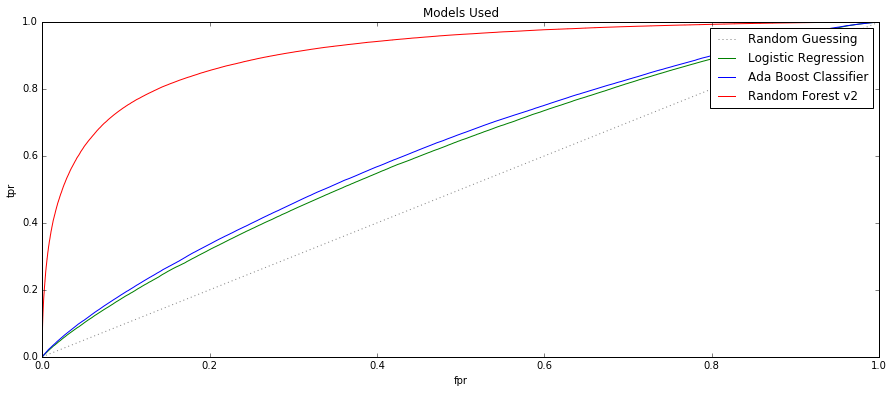

In [55]:
# ROC Plots

plt.figure(figsize=(15,6))
plt.xlim([-0., 1.])
plt.ylim([0, 1.])
plt.title('Models Used')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0,1],[0,1], c='grey',ls=':', label='Random Guessing')
plt.plot(lr_fpr, lr_tpr,c='g',label='Logistic Regression')
plt.plot(boost_fpr, boost_tpr, c='b',label='Ada Boost Classifier')
plt.plot(rf2_fpr, rf2_tpr,c='r',label='Random Forest v2')
plt.legend()
plt.show()